First, let's import necessary modules and libraries: 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Now let's load our working dataset, `Lung Cancer`: 

In [2]:
data = pd.read_csv("Datasets/survey lung cancer.csv")
data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


The _baseline human performance_ for **Lung Cancer** detection is:
- For $Accuracy$:
  - At least **70%-80%** using _chest X-ray images_.
  - Above **85%** using _CT scans_.
- For Area Under Curve $ROC$:  
  - A value above **0.90**.  

In [75]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,309.0,62.673139,8.210301,21.0,57.0,62.0,69.0,87.0
SMOKING,309.0,1.563107,0.496806,1.0,1.0,2.0,2.0,2.0
YELLOW_FINGERS,309.0,1.569579,0.495938,1.0,1.0,2.0,2.0,2.0
ANXIETY,309.0,1.498382,0.500808,1.0,1.0,1.0,2.0,2.0
PEER_PRESSURE,309.0,1.501618,0.500808,1.0,1.0,2.0,2.0,2.0
CHRONIC DISEASE,309.0,1.504854,0.500787,1.0,1.0,2.0,2.0,2.0
FATIGUE,309.0,1.673139,0.469827,1.0,1.0,2.0,2.0,2.0
ALLERGY,309.0,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0
WHEEZING,309.0,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0
ALCOHOL CONSUMING,309.0,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

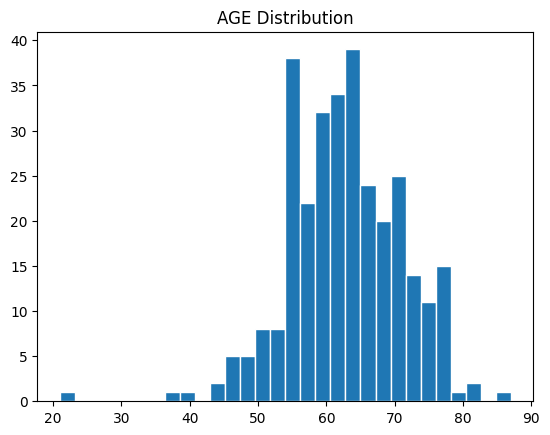

In [77]:
plt.hist(data["AGE"], bins=30, edgecolor="white")
plt.title("AGE Distribution")
plt.show()     

In [78]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

encoder = LabelEncoder()
scaler = MinMaxScaler(feature_range=(1, 2))

data["GENDER"] = encoder.fit_transform(data["GENDER"])
data["LUNG_CANCER"] = encoder.fit_transform(data["LUNG_CANCER"])

data["AGE"] = scaler.fit_transform(df[["AGE"]])

data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,1.727273,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,1.803030,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,1.575758,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,1.636364,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,1.636364,1,2,1,1,1,1,1,2,1,2,2,1,1,0


In [83]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=data["LUNG_CANCER"], random_state=40)

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9032258064516129

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.91      0.98      0.95        54

    accuracy                           0.90        62
   macro avg       0.83      0.68      0.72        62
weighted avg       0.89      0.90      0.89        62


Confusion Matrix:
 [[ 3  5]
 [ 1 53]]


**KIRC**: Kidney Renal Clear Cell Carcinoma  
**PRAD**: Prostate Adenocarcinoma  
**COAD**: Chronic Obstructive Pulmonary Disease (_Lungs_)  
**LUAD**: Lung Adenocarcinoma (_also Lungs_)  
**BRCA**: Breast Cancer $Gene$ (_consist of BCRA1 & BCRA2_)

In [72]:
data["LUNG_CANCER"].value_counts()

LUNG_CANCER
1    270
0     39
Name: count, dtype: int64